In [14]:
import numpy as np
import math
import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# --- Shell in light years (Earth-centered) ---
r1_ly = 16408.70211 #lower radius in light-years
r2_ly = 16428.70211 #upper radius in light-years
ly_to_pc = 0.306601
r1 = r1_ly * ly_to_pc  # pc
r2 = r2_ly * ly_to_pc  # pc

# --- Galactic / stellar population parameters for G-type stars ---
R0_pc = 8122.0         # Sun galactocentric radius in pc (8.122 kpc)
Rd = 2600.0            # radial scale length for G stars (pc) - adjustable
hz = 300.0             # vertical scale height for G stars (pc) - adjustable
Rmax = 15000.0         # radial limit for normalization (pc)

# Spiral arms: try to load reid_arms.csv (name,R_ref_pc,phi_ref_deg,pitch_deg), else fallback to 4-arm model

PROJECT_ROOT = Path.cwd().parent
DATA = PROJECT_ROOT / "Data"

csv_path = DATA / "reid_arms.csv"
print("Checking:", csv_path.resolve())
print("Exists:", csv_path.exists())

use_reid_csv = (DATA / "reid_arms.csv").exists()

#output directory
outdir = PROJECT_ROOT / "Results"
outdir.mkdir(exist_ok=True)

n_arms = 4
pitch_deg = 12.0
arm_half_width = 300.0  # pc, adjust for narrower/wider arms

# Population: total number of G-type stars in galaxy (adjustable). Default chosen as 2e10 (20 billion) but try values 5e9..5e10
N_total_G = 2.0e10

# Monte Carlo samples (adjust to trade speed/precision)
N_mc = 200000

# helper to normalize surface density to total N within Rmax
def compute_sigma0(N_total, Rd, Rmax):
    # integral of 2π R exp(-R/Rd) dR from 0..Rmax
    integral = 2 * math.pi * Rd**2 * (1 - math.exp(-Rmax/Rd)*(1 + Rmax/Rd))
    return N_total / integral

sigma0 = compute_sigma0(N_total_G, Rd, Rmax)

# load arms if CSV available
arm_params = []
if use_reid_csv:
    try:
        import csv
        with csv_path.open('r', newline='', encoding='utf-8') as f:
            reader = csv.reader(f)
            for row in reader:
                if len(row) < 4:
                    continue
                name = row[0]
                R_ref = float(row[1])
                phi_ref = math.radians(float(row[2]))
                pitch = math.radians(float(row[3]))
                arm_params.append(dict(name=name, R_ref=R_ref, phi_ref=phi_ref, pitch=pitch))
        print('Loaded arm parameters from reid_arms.csv')
    except Exception as e:
        print('Failed to read reid_arms.csv, falling back to parametric arms:', e)
        arm_params = []

# fallback parametric arms
if not arm_params:
    pitch = math.radians(pitch_deg)
    r_ref = R0_pc
    phi0 = 0.0
    for k in range(n_arms):
        phi_ref_k = phi0 + k * (2.0*math.pi / n_arms)
        arm_params.append(dict(name=f'arm{k+1}', R_ref=r_ref, phi_ref=phi_ref_k, pitch=pitch))

# Monte Carlo sample points uniformly in shell volume
u = np.random.uniform(r1**3, r2**3, size=N_mc)
r = u ** (1.0/3.0)
cos_theta = np.random.uniform(-1.0, 1.0, size=N_mc)
theta = np.arccos(cos_theta)
phi = np.random.uniform(0.0, 2.0*math.pi, size=N_mc)

# positions in Sun-centered Cartesian coordinates (pc)
x_sun = r * np.sin(theta) * np.cos(phi)
y_sun = r * np.sin(theta) * np.sin(phi)
z_sun = r * cos_theta

# convert to Galactocentric coordinates: place Sun at (R0, 0, 0)
X_gc = R0_pc + x_sun
Y_gc = y_sun
Z_gc = z_sun

R_gc = np.sqrt(X_gc**2 + Y_gc**2)
phi_gc = np.arctan2(Y_gc, X_gc)  # -pi..pi

# surface density at R (pc^-2)
sigma = sigma0 * np.exp(-R_gc / Rd)
# volumetric density using exponential vertical distribution: rho = sigma/(2*hz) * exp(-|z|/hz)
rho = sigma / (2.0 * hz) * np.exp(-np.abs(Z_gc) / hz)

# Determine arm membership using a local phi window search for minimal radial separation
phi_window_half = math.radians(6.0)
n_phi_samples = 121
phi_offsets = np.linspace(-phi_window_half, phi_window_half, n_phi_samples)
sep_min = np.full(N_mc, np.inf)
for arm in arm_params:
    R_ref = arm['R_ref']
    phi_ref = arm['phi_ref']
    pitch = arm['pitch']
    tan_p = math.tan(pitch)
    phi_grid = (phi_gc[:, None] + phi_offsets[None, :])
    phi_rel = (phi_grid - phi_ref + math.pi) % (2.0*math.pi) - math.pi
    R_arm_grid = R_ref * np.exp(phi_rel * tan_p)
    radial_sep_grid = np.abs(R_gc[:, None] - R_arm_grid)
    sep_min = np.minimum(sep_min, np.min(radial_sep_grid, axis=1))

in_arm = sep_min < arm_half_width

# compute full spherical shell volume
V_shell = 4.0/3.0 * math.pi * (r2**3 - r1**3)

# expected numbers
mean_rho = np.mean(rho)
N_expected_shell = mean_rho * V_shell
mean_rho_in_arms = np.mean(rho * in_arm)
N_expected_arms = mean_rho_in_arms * V_shell

# geometric arm fraction
frac_points_in_arm = np.mean(in_arm)

# print diagnostics and sensitivity over N_total_G
print(f"Shell radii: {r1_ly}..{r2_ly} ly -> {r1:.1f}..{r2:.1f} pc; N_mc={N_mc}")
print(f"Disk params: R0={R0_pc} pc, Rd={Rd} pc, hz={hz} pc, sigma0={sigma0:.3e} pc^-2")
print(f"Arms used: {len(arm_params)} (CSV loaded: {use_reid_csv})")
print('---')
print(f"Shell volume = {V_shell:.3e} pc^3")
print(f"Mean volumetric density in shell = {mean_rho:.3e} pc^-3")
print(f"Expected G stars in shell (all) = {N_expected_shell:.3f}")
print(f"Density-weighted expected in arms = {N_expected_arms:.3f}")
print(f"Geometric fraction of sampled points in arm region = {frac_points_in_arm:.4f}")

for Ntot in [5e9, 1e10, 2e10, 5e10]:
    sigma0_loc = compute_sigma0(Ntot, Rd, Rmax)
    sigma_loc = sigma0_loc * np.exp(-R_gc / Rd)
    rho_loc = sigma_loc / (2.0 * hz) * np.exp(-np.abs(Z_gc) / hz)
    Nloc = np.mean(rho_loc * in_arm) * V_shell
    print(f"N_total_G={Ntot:.2e} -> Expected in arms ≈ {Nloc:.3f}")

result = dict(V_shell=V_shell, N_expected_shell=float(N_expected_shell), N_expected_arms=float(N_expected_arms), frac_points_in_arm=float(frac_points_in_arm), params=dict(R0_pc=R0_pc, Rd=Rd, hz=hz, arm_half_width=arm_half_width, N_total_G=N_total_G))

# write results to JSON
with open(outdir / "g_star_results.json", 'w') as f:
    json.dump(result, f, indent=2)

print('\nResults written to g_star_results.json')
print(json.dumps(result, indent=2))

Checking: C:\Users\babak\Desktop\Innovation\Sumerian Kings\Data\reid_arms.csv
Exists: True
Loaded arm parameters from reid_arms.csv
Shell radii: 16408.70211..16428.70211 ly -> 5030.9..5037.1 pc; N_mc=200000
Disk params: R0=8122.0 pc, Rd=2600.0 pc, hz=300.0 pc, sigma0=4.810e+02 pc^-2
Arms used: 4 (CSV loaded: True)
---
Shell volume = 1.953e+09 pc^3
Mean volumetric density in shell = 3.485e-03 pc^-3
Expected G stars in shell (all) = 6805638.408
Density-weighted expected in arms = 1604110.493
Geometric fraction of sampled points in arm region = 0.2521
N_total_G=5.00e+09 -> Expected in arms ≈ 401027.623
N_total_G=1.00e+10 -> Expected in arms ≈ 802055.246
N_total_G=2.00e+10 -> Expected in arms ≈ 1604110.493
N_total_G=5.00e+10 -> Expected in arms ≈ 4010276.232

Results written to g_star_results.json
{
  "V_shell": 1952712296.846516,
  "N_expected_shell": 6805638.4082459705,
  "N_expected_arms": 1604110.4929011413,
  "frac_points_in_arm": 0.252085,
  "params": {
    "R0_pc": 8122.0,
    "Rd":

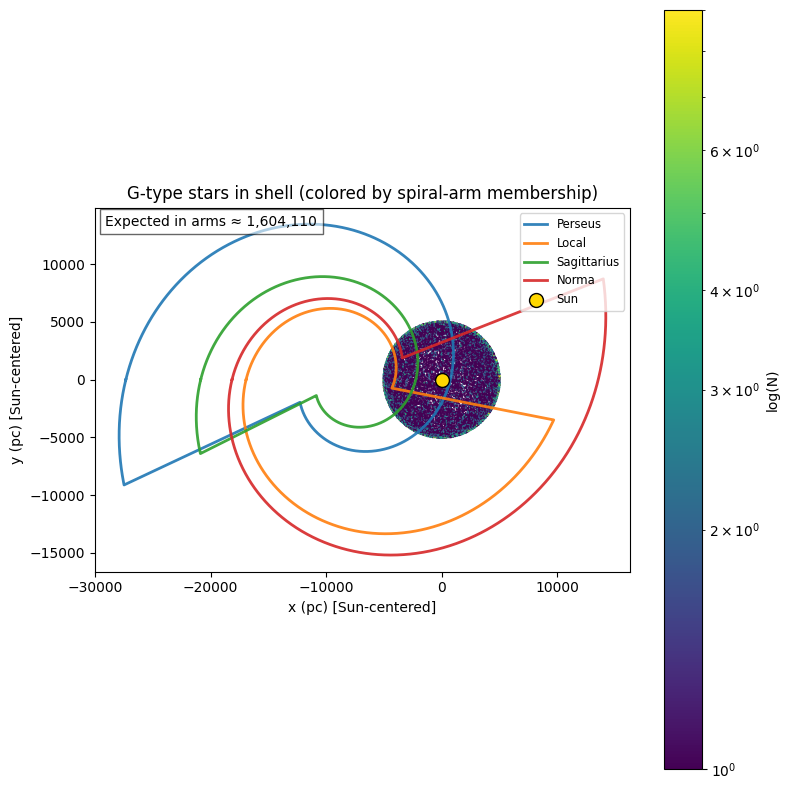

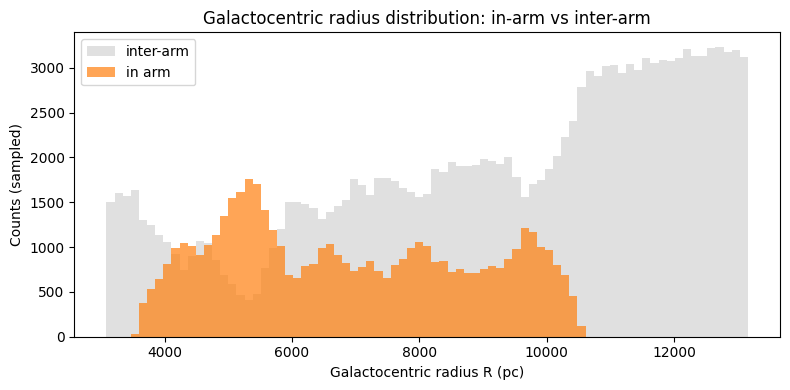

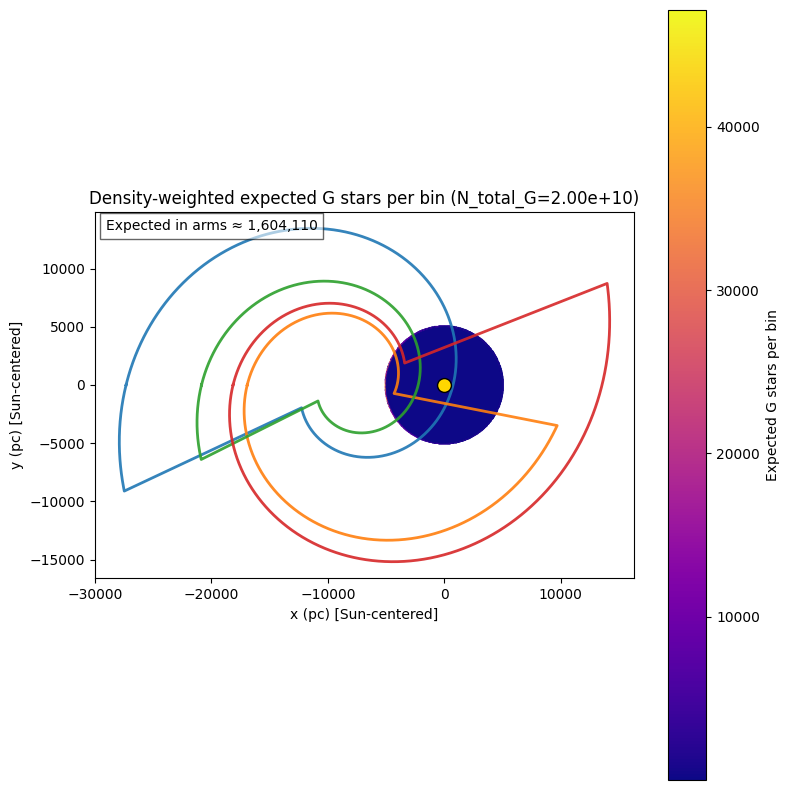

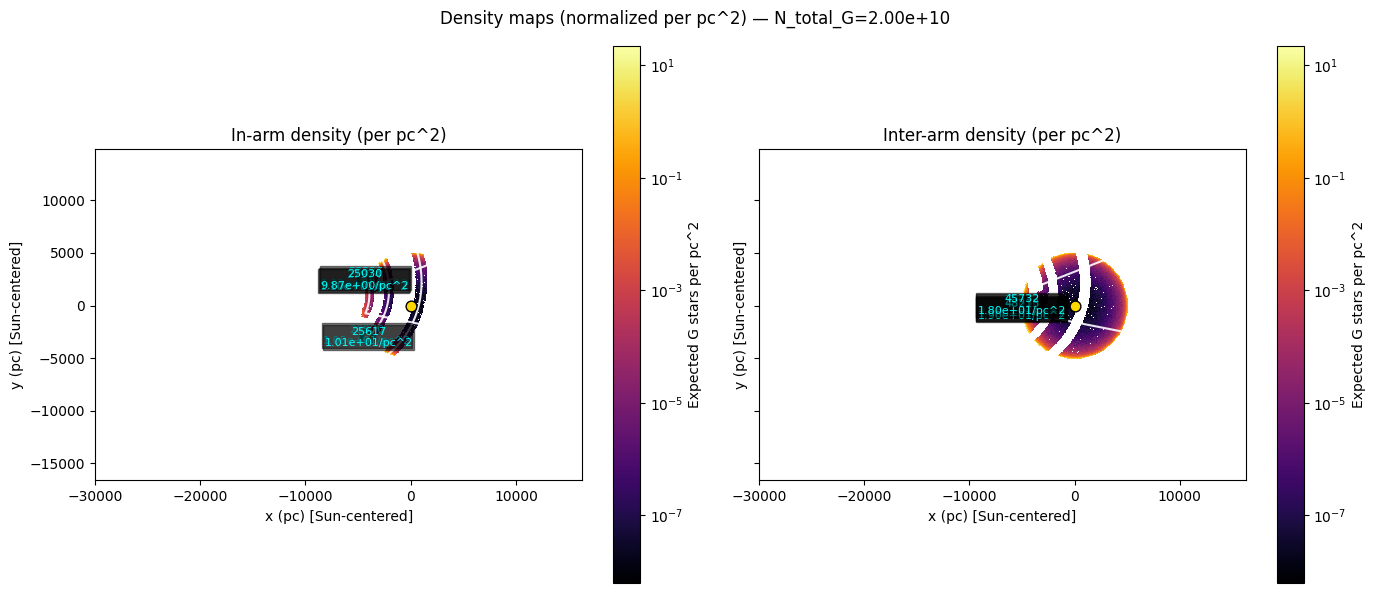

In [15]:
# Plot sampled points and overlay arm loci
import matplotlib.pyplot as plt

# Subsample for plotting to keep it responsive
plot_n = min(20000, N_mc)
idx = np.random.choice(N_mc, size=plot_n, replace=False)
x_plot = x_sun[idx]
y_plot = y_sun[idx]
in_arm_plot = in_arm[idx]

try:
    plt.style.use('seaborn-whitegrid')
except Exception:
    plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,8))

hb = ax.hexbin(x_plot, y_plot, gridsize=200, cmap='viridis', bins='log')
fig.colorbar(hb, ax=ax, label='log(N)')

# overlay parametric arm loci (converted to Sun-centered coordinates)
phi_plot = np.linspace(-np.pi, np.pi, 2000)
for arm in arm_params:
    R_ref = arm['R_ref']
    phi_ref = arm['phi_ref']
    pitch = arm['pitch']
    tan_p = math.tan(pitch)
    phi_rel = (phi_plot - phi_ref + np.pi) % (2.0*math.pi) - np.pi
    R_arm = R_ref * np.exp(phi_rel * tan_p)
    X_arm = R_arm * np.cos(phi_plot)
    Y_arm = R_arm * np.sin(phi_plot)
    # convert Galactocentric (X_arm,Y_arm) to Sun-centered by subtracting R0 along x
    x_arm = X_arm - R0_pc
    y_arm = Y_arm
    ax.plot(x_arm, y_arm, '-', lw=2, alpha=0.9, label=arm.get('name', 'arm'))

# Mark Sun at (0,0)
ax.scatter(0.0, 0.0, c='gold', edgecolor='k', s=100, zorder=10, label='Sun')
ax.set_aspect('equal', 'box')
ax.set_xlabel('x (pc) [Sun-centered]')
ax.set_ylabel('y (pc) [Sun-centered]')
ax.set_title('G-type stars in shell (colored by spiral-arm membership)')
ax.legend(loc='upper right', fontsize='small', ncol=1)
ax.text(0.02, 0.98, f"Expected in arms ≈ {N_expected_arms:,.0f}", transform=ax.transAxes, va='top', bbox=dict(facecolor='white', alpha=0.6))
plt.tight_layout()
plt.show()

# Secondary figure: distribution of Galactocentric radius for in-arm vs inter-arm
fig2, ax2 = plt.subplots(figsize=(8,4))
bins = np.linspace(max(0, R_gc.min()), R_gc.max(), 80)
ax2.hist(R_gc[~in_arm], bins=bins, color='lightgray', alpha=0.7, label='inter-arm')
ax2.hist(R_gc[in_arm], bins=bins, color='C1', alpha=0.7, label='in arm')
ax2.set_xlabel('Galactocentric radius R (pc)')
ax2.set_ylabel('Counts (sampled)')
ax2.set_title('Galactocentric radius distribution: in-arm vs inter-arm')
ax2.legend()
plt.tight_layout()
plt.show()


fig.savefig(outdir / "g_star_spiral_arms.png", dpi=200)
fig2.savefig(outdir / "g_star_radius_hist.png", dpi=200)

# Density-weighted hexbin (expected number of G stars per spatial bin)
weights = rho * (V_shell / N_mc)  # expected number contributed by each Monte Carlo sample
# choose a reasonable plotting subsample to keep rendering fast
plot_n_density = min(200000, N_mc)
idx_density = np.random.choice(N_mc, size=plot_n_density, replace=False)

fig3, ax3 = plt.subplots(figsize=(8,8))
hb3 = ax3.hexbin(x_sun[idx_density], y_sun[idx_density], C=weights[idx_density],
                 reduce_C_function=np.sum, gridsize=200, cmap='plasma')
fig3.colorbar(hb3, ax=ax3, label='Expected G stars per bin')

# overlay arm loci
phi_plot = np.linspace(-np.pi, np.pi, 2000)
for arm in arm_params:
    R_ref = arm['R_ref']
    phi_ref = arm['phi_ref']
    pitch = arm['pitch']
    tan_p = math.tan(pitch)
    phi_rel = (phi_plot - phi_ref + np.pi) % (2.0*math.pi) - np.pi
    R_arm = R_ref * np.exp(phi_rel * tan_p)
    X_arm = R_arm * np.cos(phi_plot)
    Y_arm = R_arm * np.sin(phi_plot)
    x_arm = X_arm - R0_pc
    y_arm = Y_arm
    ax3.plot(x_arm, y_arm, '-', lw=2, alpha=0.9)

# Mark Sun and annotation
ax3.scatter(0.0, 0.0, c='gold', edgecolor='k', s=100, zorder=10)
ax3.text(0.02, 0.98, f"Expected in arms ≈ {N_expected_arms:,.0f}", transform=ax3.transAxes, va='top', bbox=dict(facecolor='white', alpha=0.6))
ax3.set_aspect('equal', 'box')
ax3.set_xlabel('x (pc) [Sun-centered]')
ax3.set_ylabel('y (pc) [Sun-centered]')
ax3.set_title(f'Density-weighted expected G stars per bin (N_total_G={N_total_G:.2e})')
plt.tight_layout()
fig3.savefig(outdir / "g_star_spiral_density_weighted.png", dpi=200)
plt.show()

# -----------------------------------------------------------------------------
# Two-panel normalized density maps (in-arm vs inter-arm), normalized to per pc^2
# -----------------------------------------------------------------------------
from matplotlib.colors import LogNorm

nbins = 200
# define a grid covering the plotted region (use same extent as hexbin plot)
xmin, xmax = x_sun.min(), x_sun.max()
ymin, ymax = y_sun.min(), y_sun.max()
x_edges = np.linspace(xmin, xmax, nbins+1)
y_edges = np.linspace(ymin, ymax, nbins+1)

dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]

# compute weighted 2D histograms (expected counts per bin)
hist_in, _, _ = np.histogram2d(x_sun[in_arm], y_sun[in_arm], bins=[x_edges, y_edges], weights=weights[in_arm])
hist_out, _, _ = np.histogram2d(x_sun[~in_arm], y_sun[~in_arm], bins=[x_edges, y_edges], weights=weights[~in_arm])

# normalize to per pc^2
density_in = hist_in / (dx * dy)
density_out = hist_out / (dx * dy)

# prepare shared log scale limits (avoid zeros)
positive_vals = np.concatenate([density_in[density_in>0].ravel(), density_out[density_out>0].ravel()])
if positive_vals.size > 0:
    vmin = positive_vals.min()
    vmax = positive_vals.max()
else:
    vmin, vmax = 1e-8, 1.0

fig4, (ax4a, ax4b) = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
X, Y = np.meshgrid(x_edges, y_edges)

pcm1 = ax4a.pcolormesh(X, Y, density_in.T, norm=LogNorm(vmin=vmin, vmax=vmax), cmap='inferno', shading='auto')
fig4.colorbar(pcm1, ax=ax4a, label='Expected G stars per pc^2')
ax4a.set_title('In-arm density (per pc^2)')

pcm2 = ax4b.pcolormesh(X, Y, density_out.T, norm=LogNorm(vmin=vmin, vmax=vmax), cmap='inferno', shading='auto')
fig4.colorbar(pcm2, ax=ax4b, label='Expected G stars per pc^2')
ax4b.set_title('Inter-arm density (per pc^2)')

# overlay arm loci on both panels
for ax_ in (ax4a, ax4b):
    for arm in arm_params:
        R_ref = arm['R_ref']
        phi_ref = arm['phi_ref']
        pitch = arm['pitch']
        tan_p = math.tan(pitch)
        phi_rel = (phi_plot - phi_ref + np.pi) % (2.0*math.pi) - np.pi
        R_arm = R_ref * np.exp(phi_rel * tan_p)
        X_arm = R_arm * np.cos(phi_plot)
        Y_arm = R_arm * np.sin(phi_plot)
        x_arm = X_arm - R0_pc
        y_arm = Y_arm
        ax_.plot(x_arm, y_arm, '-', lw=1.5, alpha=0.9, color='white')
    ax_.scatter(0.0, 0.0, c='gold', edgecolor='k', s=60, zorder=10)
    ax_.set_aspect('equal', 'box')
    ax_.set_xlabel('x (pc) [Sun-centered]')
    ax_.set_ylabel('y (pc) [Sun-centered]')

# Annotate top N bins for each panel
def annotate_top_bins(ax, hist, x_edges, y_edges, top_n=5):
    flat_idx = np.argsort(hist.ravel())[::-1]
    cnt = 0
    for idx in flat_idx:
        if hist.ravel()[idx] <= 0:
            continue
        ix, iy = np.unravel_index(idx, hist.shape)
        cx = 0.5*(x_edges[ix] + x_edges[ix+1])
        cy = 0.5*(y_edges[iy] + y_edges[iy+1])
        val = hist[ix, iy]
        dens = val / (dx*dy)
        ax.scatter(cx, cy, s=80, facecolors='none', edgecolors='cyan', linewidths=1.5)
        ax.text(cx, cy, f"{val:.0f}\n{dens:.2e}/pc^2", color='cyan', fontsize=8, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5, pad=1))
        cnt += 1
        if cnt >= top_n:
            break

annotate_top_bins(ax4a, hist_in, x_edges, y_edges, top_n=5)
annotate_top_bins(ax4b, hist_out, x_edges, y_edges, top_n=5)

fig4.suptitle(f'Density maps (normalized per pc^2) — N_total_G={N_total_G:.2e}')
plt.tight_layout()
fig4.savefig(outdir / "g_star_in_vs_inter_density.png", dpi=200)
plt.show()

In [16]:
# Export density grids and metadata to Results/


# compute bin centers
x_centers = 0.5*(x_edges[:-1] + x_edges[1:])
y_centers = 0.5*(y_edges[:-1] + y_edges[1:])
xx, yy = np.meshgrid(x_centers, y_centers, indexing='xy')

# flatten and write CSV: one row per grid cell
rows = np.column_stack([
    xx.ravel(),
    yy.ravel(),
    hist_in.ravel(),
    (hist_in/(dx*dy)).ravel(),
    hist_out.ravel(),
    (hist_out/(dx*dy)).ravel(),
])
header = 'x_center,y_center,hist_in_expected,hist_in_per_pc2,hist_out_expected,hist_out_per_pc2'

out_csv = outdir / 'g_star_density_grids.csv'
np.savetxt(out_csv, rows, delimiter=',', header=header, comments='')
print('Saved:', out_csv)

# save metadata for reproducibility
meta = dict(
    N_total_G=float(N_total_G), Rd=float(Rd), hz=float(hz),
    nbins=int(nbins), dx=float(dx), dy=float(dy),
    V_shell=float(V_shell), N_expected_arms=float(N_expected_arms)
)
out_meta = outdir / 'g_star_density_metadata.json'
with out_meta.open('w') as f:
    json.dump(meta, f, indent=2)
print('Saved:', out_meta)

# also save compact numpy archive for quick reloading
np.savez(outdir / 'g_star_density_grids.npz', hist_in=hist_in, hist_out=hist_out, x_edges=x_edges, y_edges=y_edges)
print('Saved: g_star_density_grids.npz')

Saved: c:\Users\babak\Desktop\Innovation\Sumerian Kings\Results\g_star_density_grids.csv
Saved: c:\Users\babak\Desktop\Innovation\Sumerian Kings\Results\g_star_density_metadata.json
Saved: g_star_density_grids.npz


Loading: c:\Users\babak\Desktop\Innovation\Sumerian Kings\Results\g_star_density_grids.csv
Saved: c:\Users\babak\Desktop\Innovation\Sumerian Kings\Results\g_star_in_vs_inter_density_from_csv.png


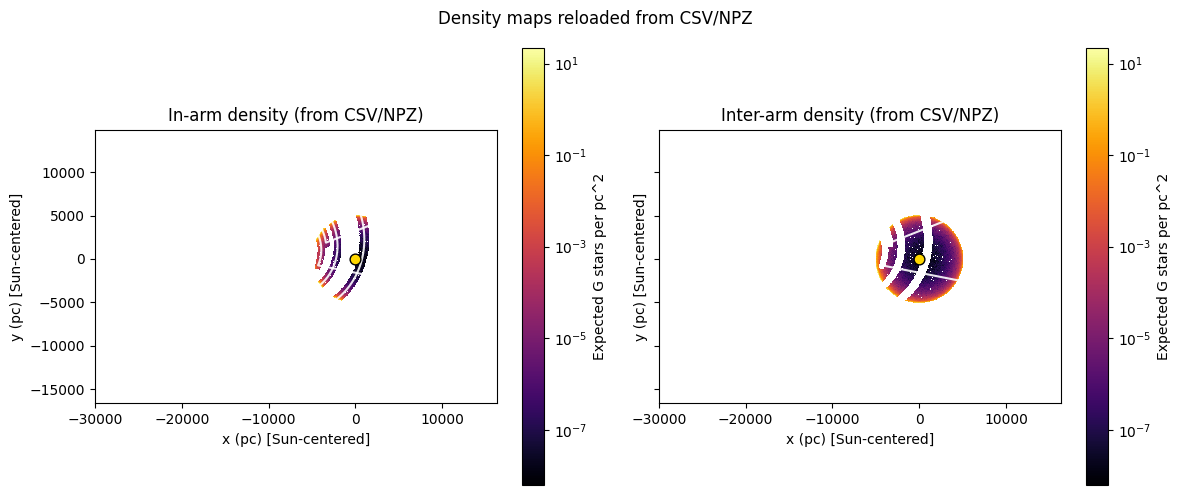

In [17]:
# Example: load exported density grids and re-plot (CSV / NPZ)

print('Loading:', outdir / 'g_star_density_grids.csv')

df = pd.read_csv(outdir / 'g_star_density_grids.csv')
npz = np.load(outdir / 'g_star_density_grids.npz')

x_edges = np.asarray(npz['x_edges'])
y_edges = np.asarray(npz['y_edges'])
hist_in = np.asarray(npz['hist_in'])
hist_out = np.asarray(npz['hist_out'])

# normalize to per pc^2
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
density_in = hist_in / (dx * dy)
density_out = hist_out / (dx * dy)

# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)
# choose log-scale limits from positive values
pos = np.concatenate([density_in[density_in>0].ravel(), density_out[density_out>0].ravel()])
if pos.size > 0:
    vmin = pos.min()
    vmax = pos.max()
else:
    vmin, vmax = 1e-8, 1.0

pcm1 = ax1.pcolormesh(x_edges, y_edges, density_in.T, norm=LogNorm(vmin=vmin, vmax=vmax), cmap='inferno', shading='auto')
fig.colorbar(pcm1, ax=ax1, label='Expected G stars per pc^2')
ax1.set_title('In-arm density (from CSV/NPZ)')

pcm2 = ax2.pcolormesh(x_edges, y_edges, density_out.T, norm=LogNorm(vmin=vmin, vmax=vmax), cmap='inferno', shading='auto')
fig.colorbar(pcm2, ax=ax2, label='Expected G stars per pc^2')
ax2.set_title('Inter-arm density (from CSV/NPZ)')

# overlay arm loci on both panels
phi_plot = np.linspace(-np.pi, np.pi, 2000)
for ax in (ax1, ax2):
    for arm in arm_params:
        R_ref = arm['R_ref']
        phi_ref = arm['phi_ref']
        pitch = arm['pitch']
        tan_p = math.tan(pitch)
        phi_rel = (phi_plot - phi_ref + np.pi) % (2.0*math.pi) - np.pi
        R_arm = R_ref * np.exp(phi_rel * tan_p)
        X_arm = R_arm * np.cos(phi_plot)
        Y_arm = R_arm * np.sin(phi_plot)
        x_arm = X_arm - R0_pc
        y_arm = Y_arm
        ax.plot(x_arm, y_arm, '-', lw=1.5, alpha=0.9, color='white')
    ax.scatter(0.0, 0.0, c='gold', edgecolor='k', s=60, zorder=10)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('x (pc) [Sun-centered]')
    ax.set_ylabel('y (pc) [Sun-centered]')

plt.suptitle('Density maps reloaded from CSV/NPZ')
plt.tight_layout()
outfile = outdir / 'g_star_in_vs_inter_density_from_csv.png'
fig.savefig(outfile, dpi=200)
print('Saved:', outfile)
plt.show()

### Interactive Plot: in-arm vs inter-arm (Plotly)

This cell creates an interactive Plotly figure (two panels) showing the per-pc^2 density maps. Hover shows x, y, and density values. It saves an HTML file to `Results/` for sharing or inspection in a browser.

In [18]:
# Create Plotly interactive two-panel heatmap (in-arm vs inter-arm)
try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
except Exception as e:
    print('Plotly not available. To enable interactive figures install plotly: pip install plotly')
else:
    # prepare centers and z arrays
    x_centers = 0.5*(x_edges[:-1] + x_edges[1:])
    y_centers = 0.5*(y_edges[:-1] + y_edges[1:])

    fig = make_subplots(rows=1, cols=2, subplot_titles=(f'In-arm density (per pc^2) — N_tot={N_total_G:.2e}', 'Inter-arm density (per pc^2)'), shared_yaxes=True)

    hm1 = go.Heatmap(x=x_centers, y=y_centers, z=density_in.T, colorscale='Inferno', colorbar=dict(title='G stars/pc^2'), hovertemplate='x:%{x:.0f}<br>y:%{y:.0f}<br>dens:%{z:.3e}<extra></extra>')
    hm2 = go.Heatmap(x=x_centers, y=y_centers, z=density_out.T, colorscale='Inferno', colorbar=dict(title='G stars/pc^2'), hovertemplate='x:%{x:.0f}<br>y:%{y:.0f}<br>dens:%{z:.3e}<extra></extra>')

    fig.add_trace(hm1, row=1, col=1)
    fig.add_trace(hm2, row=1, col=2)

    # overlay spiral arm loci and Sun marker on both panels
    for arm in arm_params:
        R_ref = arm['R_ref']
        phi_ref = arm['phi_ref']
        pitch = arm['pitch']
        tan_p = math.tan(pitch)
        phi_rel = (phi_plot - phi_ref + math.pi) % (2.0*math.pi) - math.pi
        R_arm = R_ref * np.exp(phi_rel * tan_p)
        X_arm = R_arm * np.cos(phi_plot)
        Y_arm = R_arm * np.sin(phi_plot)
        x_arm = X_arm - R0_pc
        y_arm = Y_arm
        fig.add_trace(go.Scatter(x=x_arm, y=y_arm, mode='lines', line=dict(color='white', width=1.5), showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=x_arm, y=y_arm, mode='lines', line=dict(color='white', width=1.5), showlegend=False), row=1, col=2)

    # Sun marker
    sun_trace = go.Scatter(x=[0], y=[0], mode='markers', marker=dict(color='gold', size=10, line=dict(color='black', width=1)), name='Sun')
    fig.add_trace(sun_trace, row=1, col=1)
    fig.add_trace(go.Scatter(x=[0], y=[0], mode='markers', marker=dict(color='gold', size=10, line=dict(color='black', width=1)), showlegend=False), row=1, col=2)

    fig.update_layout(height=650, width=1100, title_text='Interactive density maps (in-arm vs inter-arm)')

    # save interactive html
    out_html = outdir / 'g_star_in_vs_inter_density_interactive.html'
    fig.write_html(str(out_html))
    print('Saved interactive HTML:', out_html)

    # try saving a static PNG (requires kaleido)
    try:
        out_png = outdir / 'g_star_in_vs_inter_density_interactive.png'
        fig.write_image(str(out_png), scale=2)
        print('Saved static PNG (requires kaleido):', out_png)
    except Exception as e:
        # print full exception to diagnose why image export failed
        import traceback
        print('Static PNG not saved — write_image raised exception:')
        traceback.print_exc()
        # try a more explicit engine call
        try:
            import plotly.io as pio
            pio.write_image(fig, str(out_png), engine='kaleido', scale=2)
            print('Saved static PNG via pio.write_image with engine=kaleido:', out_png)
        except Exception as e2:
            print('pio.write_image also failed:')
            traceback.print_exc()
            print('HTML file is viewable in a browser.')

Saved interactive HTML: c:\Users\babak\Desktop\Innovation\Sumerian Kings\Results\g_star_in_vs_inter_density_interactive.html
Saved static PNG (requires kaleido): c:\Users\babak\Desktop\Innovation\Sumerian Kings\Results\g_star_in_vs_inter_density_interactive.png


In [19]:
# Diagnostic: test kaleido availability and fig.write_image
try:
    import plotly.io as pio
    import kaleido
    print('kaleido available, version:', kaleido.__version__)
except Exception as e:
    print('kaleido import failed:', e)

# small figure test
import plotly.graph_objects as go
fig_test = go.Figure(go.Scatter(x=[0,1], y=[0,1], mode='lines+markers'))
try:
    out_test = outdir / 'kaleido_test.png'
    fig_test.write_image(str(out_test))
    print('Saved test PNG:', out_test)
except Exception as e:
    print('fig_test.write_image failed:', e)


kaleido import failed: module 'kaleido' has no attribute '__version__'
Saved test PNG: c:\Users\babak\Desktop\Innovation\Sumerian Kings\Results\kaleido_test.png


### New outputs: density grids (CSV) and metadata 📁

The notebook now writes the computed density grids and metadata to the `Results/` folder for external analysis.

- `g_star_density_grids.csv` — columns: `x_center, y_center, hist_in_expected, hist_in_per_pc2, hist_out_expected, hist_out_per_pc2` (one row per grid cell).
- `g_star_density_metadata.json` — contains parameters used to create the grids (e.g., `N_total_G`, `Rd`, `hz`, `nbins`, `dx`, `dy`, `V_shell`, `N_expected_arms`).

Load quickly with `pandas.read_csv('Results/g_star_density_grids.csv')` and reshape if desired (grid is `nbins x nbins`).